# Deep Reinforcement Learning Analysis with LunarLander-v3

## Installation and Importing of Required Libraries

In [ ]:
!apt-get install -y swig > /dev/null 2>&1
!pip install gymnasium[box2d] torch numpy matplotlib > /dev/null 2>&1

import os, random, math
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Çalışma Ortamı: {device}")

Çalışma Ortamı: cuda


## Environment Setup

In [ ]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

print(f"Ortam: LunarLander-v3")
print(f"Gözlem Uzayı Boyutu: {state_shape} (Beklenen: 8)")
print(f"Eylem Uzayı Boyutu: {action_shape} (Beklenen: 4)")

# Replay Buffer Sınıfı: Deneyim saklama ve örnekleme mekanizması
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Hafızaya yeni bir deneyim ekler."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Eğitim için rastgele bir mini-batch (küme) seçer."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

Ortam: LunarLander-v3
Gözlem Uzayı Boyutu: 8 (Beklenen: 8)
Eylem Uzayı Boyutu: 4 (Beklenen: 4)


## Neural Network Architectures

In [ ]:
# 1. Standart DQN ve Double DQN için Model
class QNetwork(nn.Module):
    """
    Standart Tam Bağlantılı (Fully Connected) Sinir Ağı.
    Durum (State) verisini alır ve h er eylem (Action) için Q-değeri üretir.
    """
    def __init__(self, state_size, action_size, seed=42):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        # 64 nöronluk iki gizli katman kullanımı
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# 2. Dueling DQN için Model
class DuelingQNetwork(nn.Module):
    """
    Dueling mimarisi: Q değerini 'Durum Değeri' (Value) ve 'Avantaj' (Advantage)
    olarak iki ayrı akışa ayırır ve sonra birleştirir.
    """
    def __init__(self, state_size, action_size, seed=42):
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        # Ortak Özellik Çıkarım Katmanları
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)

        # Ayrışma: Avantaj (Advantage) Akışı
        self.advantage_fc = nn.Linear(64, 32)
        self.advantage_out = nn.Linear(32, action_size)

        # Ayrışma: Değer (Value) Akışı
        self.value_fc = nn.Linear(64, 32)
        self.value_out = nn.Linear(32, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        # Avantaj ve Değer hesaplamaları
        adv = F.relu(self.advantage_fc(x))
        val = F.relu(self.value_fc(x))

        advantage = self.advantage_out(adv)
        value = self.value_out(val)

        # dim=1 ile batch üzerindeki her örnek için eylem ortalaması alınır.
        return value + advantage - advantage.mean(dim=1, keepdim=True)

## Google Drive Integration and Agent Class


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
CHECKPOINT_DIR = "/content/drive/My Drive/LunarLander_Models/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Hiperparametreler
BUFFER_SIZE = int(1e5)  # Hafıza boyutu
BATCH_SIZE = 128        # Her eğitim adımındaki örnek sayısı
GAMMA = 0.99            # İndirim faktörü
TAU = 0.005             # Soft update katsayısı
LR = 1e-4               # Öğrenme hızı (AdamW için optimize edildi)
UPDATE_EVERY = 4        # Ağın kaç adımda bir güncelleneceği

class Agent:
    def __init__(self, state_size, action_size, seed, model_type="DQN"):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.model_type = model_type

        # Model Tipine Göre Ağ Seçimi (Dueling Mimarisi veya Standart)
        if self.model_type == "Dueling":
            self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
            self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        else:
            # DQN ve Double DQN (DDQN) standart mimariyi kullanır
            self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)

        # Optimizer: AdamW (Daha iyi regülasyon sağlar)
        self.optimizer = optim.AdamW(self.qnetwork_local.parameters(), lr=LR, amsgrad=True)

        # Hata Fonksiyonu: Huber Loss (SmoothL1Loss) - Aykırı değerlere karşı dirençli
        self.criterion = nn.SmoothL1Loss()

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Deneyimi hafızaya kaydet
        self.memory.add(state, action, reward, next_state, done)

        # Belirli aralıklarla öğrenme işlemini tetikle
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Mevcut duruma ve Epsilon değerine göre eylem seçer."""
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-Greedy Politikası
        if random.random() > eps:
            return int(np.argmax(action_values.cpu().data.numpy()))
        else:
            return int(random.choice(np.arange(self.action_size)))

    def learn(self, experiences, gamma):
        """Deneyimlerden öğrenerek ağırlıkları günceller."""
        states, actions, rewards, next_states, dones = experiences

        # Hedef Q Değerlerinin Hesaplanması

        if self.model_type == "DDQN":
            # Double DQN: Eylemi Local ağ seçer, değerini Target ağ belirler
            best_actions_local = self.qnetwork_local(next_states).max(1)[1].unsqueeze(1)
            Q_targets_next = self.qnetwork_target(next_states).gather(1, best_actions_local)
        else:
            # Standart DQN ve Dueling DQN (Target logic standarttır)
            Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        # Bellman Denklemi
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Tahmin Edilen Q Değerleri
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Hata Hesabı ve Geri Yayılım
        loss = self.criterion(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()

        # Gradient Clipping (Eğitim stabilitesi için gradyanları kırpma)
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1.0)

        self.optimizer.step()

        # Hedef Ağı Yumuşak Güncelleme (Soft Update)
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save(self, filename):
        """Modeli Google Drive'a kaydeder."""
        path = os.path.join(CHECKPOINT_DIR, filename)
        torch.save(self.qnetwork_local.state_dict(), path)

print("Ajan Sınıfı oluşturuldu. Drive bağlantısı sağlandı.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ajan Sınıfı oluşturuldu. Drive bağlantısı sağlandı.


## Visualization of Model Architectures (Plotly)


In [ ]:
# @title
import plotly.graph_objects as go

def visualize_architectures():
    # Ortak font ayarları
    base_font = dict(family="Arial", size=14)

    fig_dqn = go.Figure(go.Funnel(
        y=["Giriş (State)", "FC1 (Gizli)", "FC2 (Gizli)", "Çıkış (Q-Values)"],
        x=[8, 64, 64, 4],  # MİMARİYİ DEĞİŞTİRMEDİK
        textinfo="value+label",
        textfont=dict(size=13),
        marker=dict(
            color=["#1f77b4", "#1f77b4", "#1f77b4", "#d62728"],
            line=dict(color="rgba(255,255,255,0.7)", width=1)
        ),
        connector=dict(line=dict(color="rgba(255,255,255,0.3)", width=1))
    ))

    fig_dqn.update_layout(
        title_text="Standart DQN & DDQN Mimarisi (Sequential)",
        template="plotly_dark",
        font=base_font,
        width=900,
        height=380,
        margin=dict(l=120, r=80, t=60, b=60)
    )

    fig_dqn.show()
    labels = [
        "Giriş (State: 8)",  # 0
        "Ortak FC1 (64)",    # 1
        "Ortak FC2 (64)",    # 2
        "Advantage (32)",    # 3
        "Value (32)",        # 4
        "Action (4)",        # 5
        "State Value (1)",   # 6
        "Aggregation (Q-Values)"  # 7
    ]

    colors = ["#1f77b4", "#1f77b4", "#1f77b4",
              "#ff7f0e", "#2ca02c", "#ff7f0e", "#2ca02c", "#d62728"]

    x_positions = [0.02, 0.20, 0.38, 0.62, 0.62, 0.80, 0.80, 0.96]
    y_positions = [0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5]

    fig_dueling = go.Figure(data=[go.Sankey(
        arrangement="fixed",  # x-y verdiğimiz için sabit kalsın
        node=dict(
            pad=20,
            thickness=18,
            line=dict(color="rgba(255,255,255,0.85)", width=1),
            label=labels,
            color=colors,
            x=x_positions,
            y=y_positions
        ),
        link=dict(
            # BAĞLANTILAR AYNI
            source=[0, 1, 2, 2, 3, 4, 5, 6],
            target=[1, 2, 3, 4, 5, 6, 7, 7],
            value=[8, 64, 32, 32, 32, 32, 4, 1],
            color="rgba(200,200,200,0.4)"
        )
    )])
    fig_dueling.update_layout(
        title_text="Dueling DQN Mimarisi (Branching Flow)",
        template="plotly_dark",
        font=base_font,
        width=1000,
        height=420,
        margin=dict(l=40, r=40, t=60, b=40)
    )
    fig_dueling.show()
visualize_architectures()

## Agent Class Update (Required for Loss Tracking)



In [ ]:
class Agent:
    def __init__(self, state_size, action_size, seed, model_type="DQN"):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.model_type = model_type

        if self.model_type == "Dueling":
            self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
            self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        else:
            self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)

        self.optimizer = optim.AdamW(self.qnetwork_local.parameters(), lr=LR, amsgrad=True)
        self.criterion = nn.SmoothL1Loss()
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        loss_val = 0 # Default loss
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                loss_val = self.learn(experiences, GAMMA)

        return loss_val

    def act(self, state, eps=0.):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return int(np.argmax(action_values.cpu().data.numpy()))
        else:
            return int(random.choice(np.arange(self.action_size)))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        if self.model_type == "DDQN":
            best_actions_local = self.qnetwork_local(next_states).max(1)[1].unsqueeze(1)
            Q_targets_next = self.qnetwork_target(next_states).gather(1, best_actions_local)
        else:
            Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = self.criterion(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1.0)
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

        return loss.item() # Loss değerini sayısal olarak döndür

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save(self, filename):
        path = os.path.join(CHECKPOINT_DIR, filename)
        torch.save(self.qnetwork_local.state_dict(), path)

print("Agent sınıfı Loss takibi için güncellendi.")

Agent sınıfı Loss takibi için güncellendi.


## Training and Visualization Utilities


In [ ]:
import pandas as pd
import plotly.express as px

def plot_training_metrics(scores, losses, model_name):
    """
    Eğitim sonrası Ödül ve Loss grafiklerini Plotly ile çizer.
    """
    # Veri Hazırlığı
    df_scores = pd.DataFrame({"Episode": range(1, len(scores)+1), "Score": scores})
    df_scores["Average Score (100)"] = df_scores["Score"].rolling(window=100, min_periods=1).mean()

    df_losses = pd.DataFrame({"Episode": range(1, len(losses)+1), "Loss": losses})
    df_losses["Average Loss (Moving)"] = df_losses["Loss"].rolling(window=50, min_periods=1).mean()

    # 1. Grafik: Ödül (Reward) Grafiği
    fig_reward = go.Figure()
    fig_reward.add_trace(go.Scatter(x=df_scores["Episode"], y=df_scores["Score"], mode='lines', name='Score', opacity=0.3, line=dict(color='cyan')))
    fig_reward.add_trace(go.Scatter(x=df_scores["Episode"], y=df_scores["Average Score (100)"], mode='lines', name='Avg Score (100)', line=dict(color='red', width=2)))
    fig_reward.update_layout(title=f"{model_name} - Eğitim Performansı (Reward)", xaxis_title="Episode", yaxis_title="Score", template="plotly_dark")
    fig_reward.show()

    # 2. Grafik: Hata (Loss) Grafiği
    fig_loss = go.Figure()
    fig_loss.add_trace(go.Scatter(x=df_losses["Episode"], y=df_losses["Loss"], mode='lines', name='Loss', opacity=0.4, line=dict(color='orange')))
    fig_loss.add_trace(go.Scatter(x=df_losses["Episode"], y=df_losses["Average Loss (Moving)"], mode='lines', name='Avg Loss', line=dict(color='red', width=2)))
    fig_loss.update_layout(title=f"{model_name} - Eğitim Kaybı (Training Loss)", xaxis_title="Episode", yaxis_title="Loss", template="plotly_dark")
    fig_loss.show()

def train_single_model(model_type, n_episodes=800):
    agent = Agent(state_shape, action_shape, seed=0, model_type=model_type)
    scores = []
    losses = [] # Loss değerlerini tutacak liste
    scores_window = deque(maxlen=100)
    eps = 1.0
    eps_end = 0.01
    eps_decay = 0.995

    print(f"\n>>> {model_type} EĞİTİMİ BAŞLIYOR...")

    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        score = 0
        episode_losses = [] # Bu bölümdeki loss değerleri

        for t in range(1000):
            action = agent.act(state, eps)
            next_state, reward, done, truncated, _ = env.step(action)

            # Loss değerini al ve kaydet
            loss_val = agent.step(state, action, reward, next_state, done)
            if loss_val != 0:
                episode_losses.append(loss_val)

            state = next_state
            score += reward
            if done or truncated:
                break

        # Bölüm sonu işlemleri
        scores_window.append(score)
        scores.append(score)

        # Bölümdeki ortalama loss'u kaydet (eğer öğrenme gerçekleştiyse)
        if episode_losses:
            losses.append(np.mean(episode_losses))
        else:
            losses.append(0)

        eps = max(eps_end, eps_decay * eps)

        if i_episode % 50 == 0:
            print(f'\rEpisode {i_episode}\tAvg Score: {np.mean(scores_window):.2f}\tAvg Loss: {np.mean(episode_losses) if episode_losses else 0:.4f}')

        if np.mean(scores_window) >= 200.0:
            print(f'\n{model_type} ÇÖZÜLDÜ! Episode: {i_episode} \tAvg Score: {np.mean(scores_window):.2f}')
            agent.save(f"{model_type}_solved.pth")
            break

    agent.save(f"{model_type}_final.pth")

    # Grafikleri Çiz
    plot_training_metrics(scores, losses, model_type)
    return scores, losses

print("Eğitim ve Grafik fonksiyonları hazırlandı.")

Eğitim ve Grafik fonksiyonları hazırlandı.


## Training Base DQN

In [ ]:
# Standart DQN Modelini Eğit
dqn_scores, dqn_losses = train_single_model("DQN", n_episodes=600)


>>> DQN EĞİTİMİ BAŞLIYOR...
Episode 50	Avg Score: -195.45	Avg Loss: 2.3570
Episode 100	Avg Score: -172.61	Avg Loss: 1.6316
Episode 150	Avg Score: -108.80	Avg Loss: 1.9402
Episode 200	Avg Score: -37.96	Avg Loss: 1.5996
Episode 250	Avg Score: -2.69	Avg Loss: 1.3720
Episode 300	Avg Score: -22.67	Avg Loss: 1.0406
Episode 350	Avg Score: -28.82	Avg Loss: 0.7413
Episode 400	Avg Score: -23.07	Avg Loss: 0.6369
Episode 450	Avg Score: -56.27	Avg Loss: 0.6605
Episode 500	Avg Score: -49.81	Avg Loss: 0.6282
Episode 550	Avg Score: -7.08	Avg Loss: 0.6244
Episode 600	Avg Score: 60.64	Avg Loss: 0.8208


## Loading Pretrained Base DQN Agent and Recording Evaluation Video

In [ ]:
import imageio
from IPython.display import Video

agent_dqn = Agent(state_shape, action_shape, seed=0, model_type="DQN")

def save_agent_video(agent, env_name, model_path, video_filename="lunar_lander_video.mp4"):
    env = gym.make(env_name, render_mode="rgb_array")

    try:
        agent.qnetwork_local.load_state_dict(torch.load(model_path, map_location=device))
        print(f"HAFIZA YÜKLENDİ: {model_path}")
    except FileNotFoundError:
        print(f"HATA: Dosya bulunamadı -> {model_path}")
        return None

    agent.qnetwork_local.eval()

    state, _ = env.reset()
    done = False
    frames = []
    total_score = 0
    print("Video oluşturuluyor")

    while not done:
        frame = env.render()
        frames.append(frame)

        action = agent.act(state, eps=0.0)
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_score += reward

        if done or truncated:
            break

    env.close()
    imageio.mimsave(video_filename, frames, fps=30)
    print(f"Video oluşturuldu: {video_filename}")
    print(f"Test Sürüşü Puanı: {total_score:.2f}")
    return Video(video_filename, embed=True, html_attributes="controls")

model_path = "/content/drive/My Drive/LunarLander_Models/DQN_final.pth"
save_agent_video(agent_dqn, "LunarLander-v3", model_path, "DQN_Test_Inisi.mp4")

HAFIZA YÜKLENDİ: /content/drive/My Drive/LunarLander_Models/DQN_final.pth
Video oluşturuluyor, lütfen bekleyin...


Video oluşturuldu: DQN_Test_Inisi.mp4
Test Sürüşü Puanı: 216.68


## Training DDQN

In [1]:
ddqn_scores, ddqn_losses = train_single_model("DDQN", n_episodes=600)# Double DQN (DDQN)
# Model Path is DDQN_final.pth

NameError: name 'train_single_model' is not defined

# Updating Architecture and Hyperparameters

In [ ]:
# Hyperparameter Tuning
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed=42):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        # 128 Nöronluk daha geniş katmanlar
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed=42):
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)

        self.advantage_fc = nn.Linear(128, 64)
        self.advantage_out = nn.Linear(64, action_size)

        self.value_fc = nn.Linear(128, 64)
        self.value_out = nn.Linear(64, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        adv = F.relu(self.advantage_fc(x))
        val = F.relu(self.value_fc(x))

        advantage = self.advantage_out(adv)
        value = self.value_out(val)

        return value + advantage - advantage.mean(dim=1, keepdim=True)

# HİPERPARAMETRELER
BATCH_SIZE = 64         # 128 yerine 64 (Daha sıkı takip)
LR = 5e-4               # Öğrenme hızı revizesi
TAU = 1e-3              # 0.005 yerine 0.001 (Daha stabil hedef takibi)
UPDATE_EVERY = 4
BUFFER_SIZE = int(1e5)
GAMMA = 0.99

print("Modeller 128 nörona yükseltildi ve parametreler optimize edildi.")

Modeller 128 nörona yükseltildi ve parametreler optimize edildi.


## Updates

In [7]:
# @title
import pandas as pd
pd.set_option("display.max_colwidth", None)
data = {
    "Parameter": [
        "Network Width",
        "Batch Size",
        "Learning Rate",
        "TAU (Soft Update)"
    ],
    "Old Code": [
        "64 neurons (standard)",
        "128",
        "1e-4",
        "0.005"
    ],
    "New Code": [
        "128 neurons",
        "64",
        "5e-4",
        "0.001"
    ],
    "Expected Effect": [
        "Higher model capacity to learn state–action relationships.",
        "Noisier but more frequent gradient updates; may help escape local minima.",
        "Faster convergence; may reduce stability if too large.",
        "Much slower target network updates; significantly improves training stability."
    ]
}
df = pd.DataFrame(data)
df

,Parameter,Old Code,New Code,Expected Effect
0,Network Width,64 neurons (standard),128 neurons,Higher model capacity to learn state–action relationships.
1,Batch Size,128,64,Noisier but more frequent gradient updates; may help escape local minima.
2,Learning Rate,1e-4,5e-4,Faster convergence; may reduce stability if too large.
3,TAU (Soft Update),0.005,0.001,Much slower target network updates; significantly improves training stability.


## Architecture

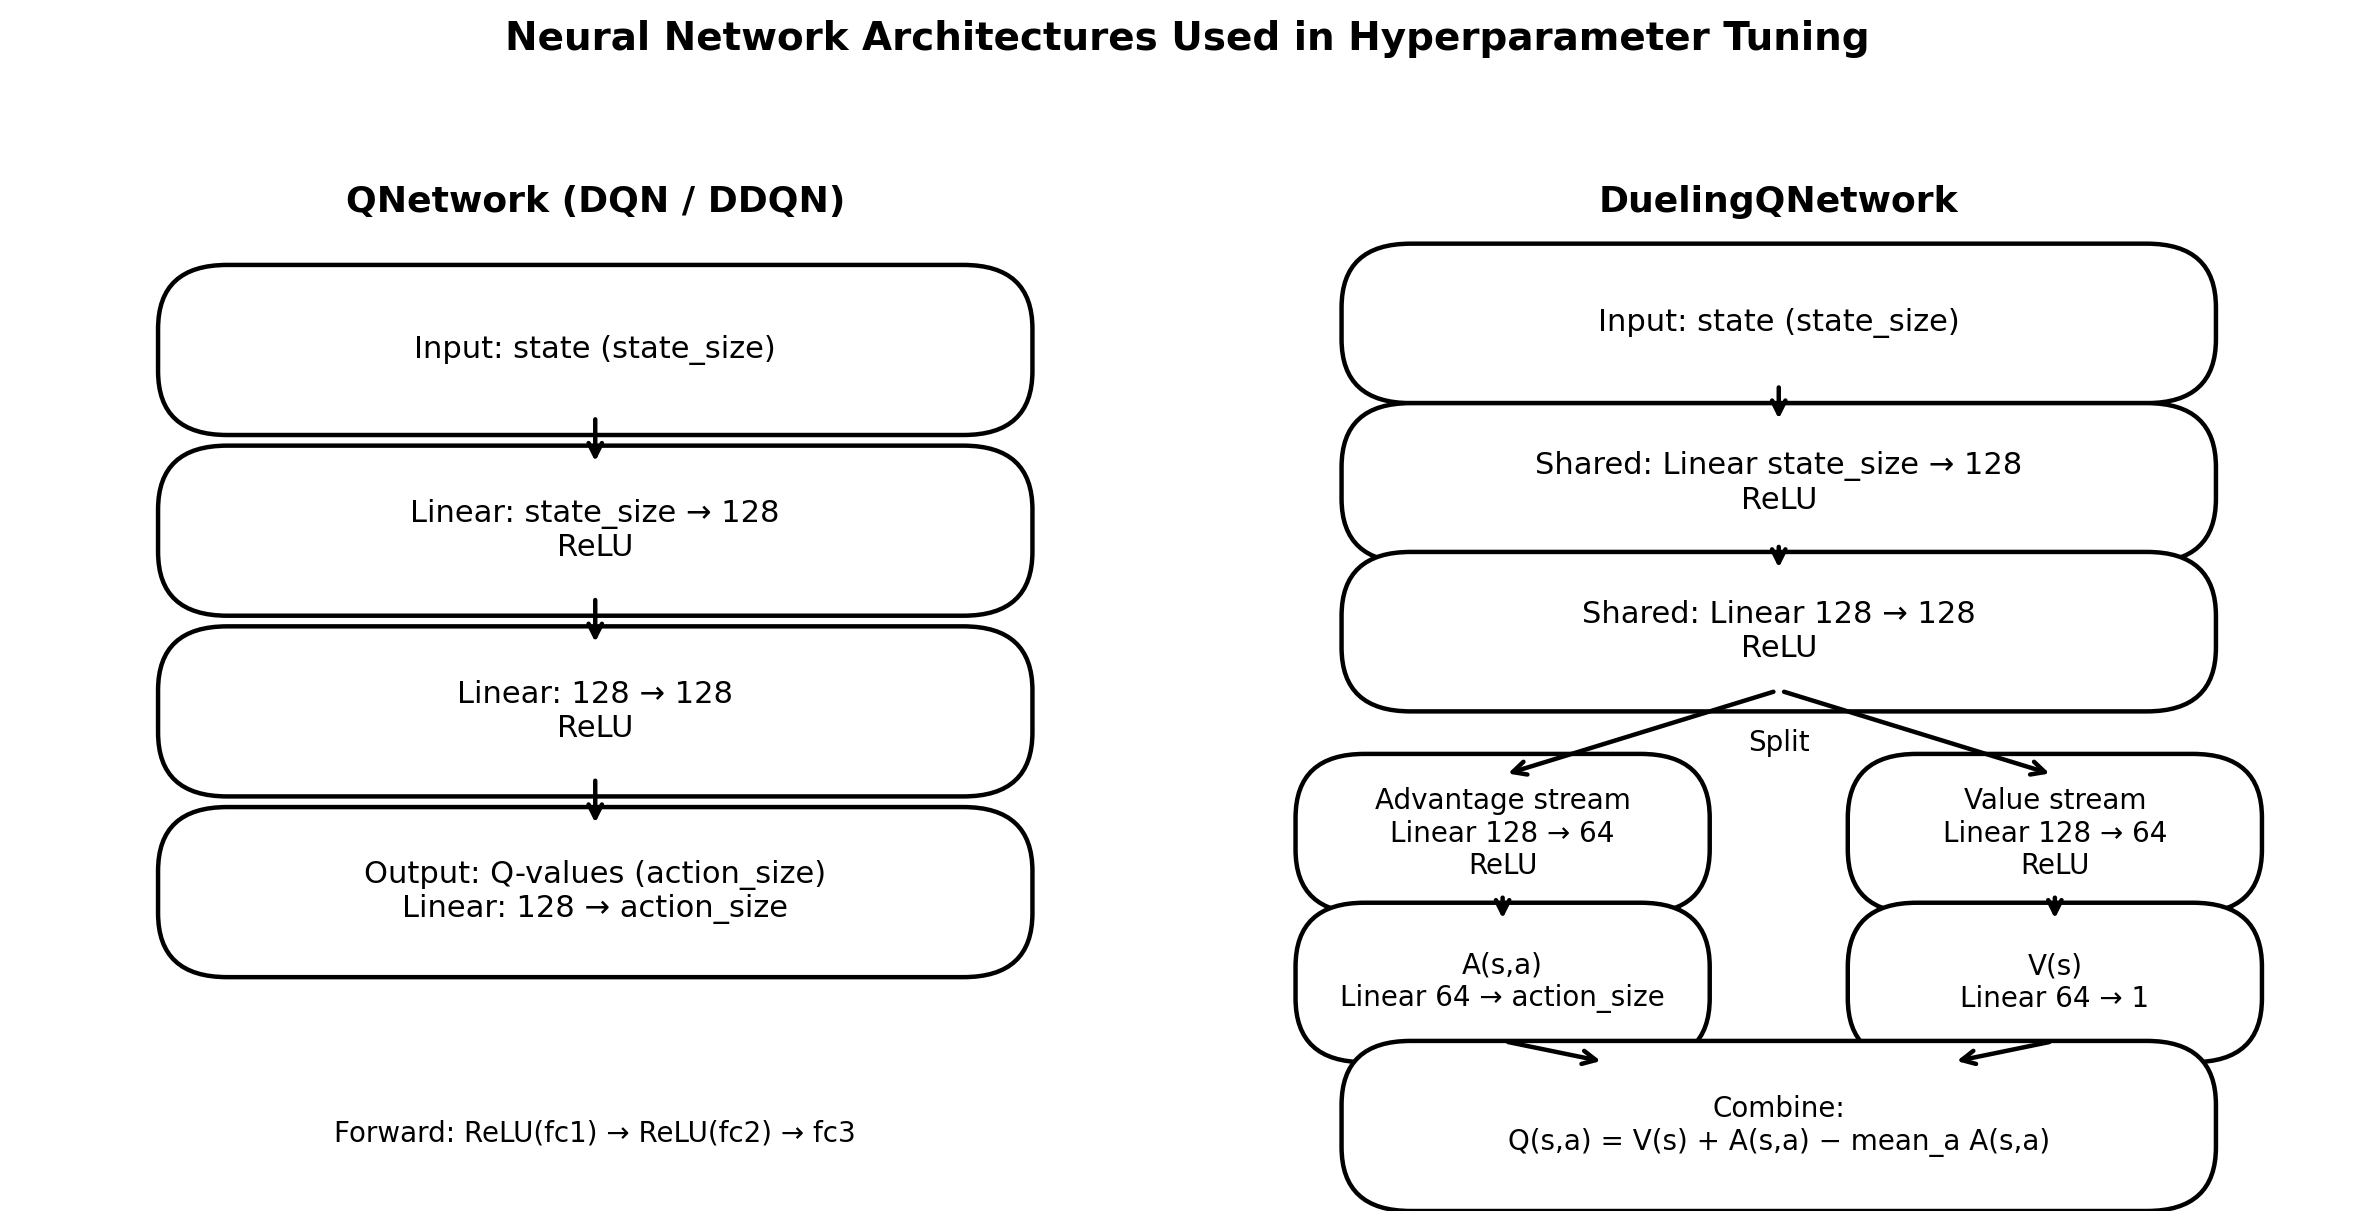

'rl_network_architectures.png'

In [2]:
# @title
# --- Clean Architecture Diagram (QNetwork + DuelingQNetwork) ---
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import matplotlib as mpl

def _draw_box(ax, x, y, w, h, text, fontsize=11, lw=1.6,
              pad=0.02, rounding=0.06):
    """Draw a rounded box with centered text."""
    box = FancyBboxPatch(
        (x, y), w, h,
        boxstyle=f"round,pad={pad},rounding_size={rounding}",
        linewidth=lw, edgecolor="black", facecolor="white"
    )
    ax.add_patch(box)
    ax.text(x + w/2, y + h/2, text, ha="center", va="center",
            fontsize=fontsize)
    return box

def _arrow(ax, x1, y1, x2, y2, lw=1.6, ms=12):
    """Draw a clean arrow."""
    arr = FancyArrowPatch(
        (x1, y1), (x2, y2),
        arrowstyle="->", mutation_scale=ms,
        linewidth=lw, color="black"
    )
    ax.add_patch(arr)
    return arr

def plot_rl_architecture_diagram(
    state_size_label="state_size",
    action_size_label="action_size",
    save_path="rl_network_architectures.png",
    show=True,
    dpi=200
):
    """
    Creates a polished architecture diagram for:
      1) QNetwork: state -> 128 -> 128 -> action
      2) DuelingQNetwork: shared trunk + value/advantage streams + combine
    """

    # Typography & rendering defaults (stable and neat)
    mpl.rcParams.update({
        "figure.dpi": dpi,
        "font.family": "DejaVu Sans",
        "font.size": 11
    })

    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    for ax in (ax1, ax2):
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis("off")

    # LEFT PANEL: QNetwork (DQN/DDQN)
    ax1.text(0.5, 0.965, "QNetwork (DQN / DDQN)",
             ha="center", va="top", fontsize=13, fontweight="bold")

    x0, w, h = 0.14, 0.72, 0.12
    ys = [0.75, 0.58, 0.41, 0.24]

    _draw_box(ax1, x0, ys[0], w, h, f"Input: state ({state_size_label})")
    _draw_box(ax1, x0, ys[1], w, h, f"Linear: {state_size_label} → 128\nReLU")
    _draw_box(ax1, x0, ys[2], w, h, "Linear: 128 → 128\nReLU")
    _draw_box(ax1, x0, ys[3], w, h, f"Output: Q-values ({action_size_label})\nLinear: 128 → {action_size_label}")

    # Centered vertical arrows (top box bottom-center to next box top-center)
    cx = x0 + w/2
    _arrow(ax1, cx, ys[0], cx, ys[1] + h)
    _arrow(ax1, cx, ys[1], cx, ys[2] + h)
    _arrow(ax1, cx, ys[2], cx, ys[3] + h)

    ax1.text(0.5, 0.06, "Forward: ReLU(fc1) → ReLU(fc2) → fc3",
             ha="center", va="bottom", fontsize=10)

    # RIGHT PANEL: DuelingQNetwork
    ax2.text(0.5, 0.965, "DuelingQNetwork",
             ha="center", va="top", fontsize=13, fontweight="bold")

    # Shared trunk
    x_t, w_t, h_t = 0.14, 0.72, 0.11
    y_in, y_fc1, y_fc2 = 0.78, 0.63, 0.49

    _draw_box(ax2, x_t, y_in,  w_t, h_t, f"Input: state ({state_size_label})")
    _draw_box(ax2, x_t, y_fc1, w_t, h_t, f"Shared: Linear {state_size_label} → 128\nReLU")
    _draw_box(ax2, x_t, y_fc2, w_t, h_t, "Shared: Linear 128 → 128\nReLU")

    cx2 = x_t + w_t/2
    _arrow(ax2, cx2, y_in,  cx2, y_fc1 + h_t)
    _arrow(ax2, cx2, y_fc1, cx2, y_fc2 + h_t)

    ax2.text(0.5, 0.44, "Split", ha="center", va="center", fontsize=10)

    # Streams
    w_s, h_s = 0.32, 0.11
    x_adv, x_val = 0.10, 0.58
    y_s1, y_s2 = 0.30, 0.16

    # Advantage stream (left)
    _draw_box(ax2, x_adv, y_s1, w_s, h_s,
              "Advantage stream\nLinear 128 → 64\nReLU", fontsize=10)
    _draw_box(ax2, x_adv, y_s2, w_s, h_s,
              f"A(s,a)\nLinear 64 → {action_size_label}", fontsize=10)

    # Value stream (right)
    _draw_box(ax2, x_val, y_s1, w_s, h_s,
              "Value stream\nLinear 128 → 64\nReLU", fontsize=10)
    _draw_box(ax2, x_val, y_s2, w_s, h_s,
              "V(s)\nLinear 64 → 1", fontsize=10)

    # From shared trunk to both streams
    _arrow(ax2, cx2, y_fc2, x_adv + w_s/2, y_s1 + h_s)
    _arrow(ax2, cx2, y_fc2, x_val + w_s/2, y_s1 + h_s)

    # Within streams
    _arrow(ax2, x_adv + w_s/2, y_s1, x_adv + w_s/2, y_s2 + h_s)
    _arrow(ax2, x_val + w_s/2, y_s1, x_val + w_s/2, y_s2 + h_s)

    # Combine box
    x_c, y_c, w_c, h_c = 0.14, 0.02, 0.72, 0.12
    _draw_box(ax2, x_c, y_c, w_c, h_c,
              "Combine:\nQ(s,a) = V(s) + A(s,a) − mean_a A(s,a)",
              fontsize=10)

    # From streams to combine
    _arrow(ax2, x_adv + w_s/2, y_s2, 0.35, y_c + h_c)
    _arrow(ax2, x_val + w_s/2, y_s2, 0.65, y_c + h_c)

    # Global title
    fig.suptitle("Neural Network Architectures Used in Hyperparameter Tuning",
                 y=1.02, fontsize=14, fontweight="bold")

    fig.tight_layout()
    fig.savefig(save_path, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)

    return save_path

# --- RUN ---
plot_rl_architecture_diagram(
    state_size_label="state_size",
    action_size_label="action_size",
    save_path="rl_network_architectures.png",
    show=True
)

## Training DDQN

In [ ]:
print(">>> DDQN Train V2")
ddqn_scores, ddqn_losses = train_single_model("DDQN", n_episodes=600)
# Model path : DDQN_solved.pth

>>> DDQN GÜÇLENDİRİLMİŞ EĞİTİM BAŞLIYOR (V2)...

>>> DDQN EĞİTİMİ BAŞLIYOR...
Episode 50	Avg Score: -151.88	Avg Loss: 1.4064
Episode 100	Avg Score: -143.39	Avg Loss: 1.4744
Episode 150	Avg Score: -113.19	Avg Loss: 1.1304
Episode 200	Avg Score: -75.65	Avg Loss: 1.2410
Episode 250	Avg Score: -37.32	Avg Loss: 0.9826
Episode 300	Avg Score: -10.31	Avg Loss: 0.6702
Episode 350	Avg Score: 19.69	Avg Loss: 0.5030
Episode 400	Avg Score: 90.75	Avg Loss: 0.5845
Episode 450	Avg Score: 158.87	Avg Loss: 0.6577
Episode 500	Avg Score: 197.51	Avg Loss: 0.6045

DDQN ÇÖZÜLDÜ! Episode: 506 	Avg Score: 201.96


## Loading Pretrained DDQN Agent and Recording Evaluation Video

In [ ]:
import os
agent_ddqn = Agent(state_shape, action_shape, seed=0, model_type="DDQN")

path_solved = "/content/drive/My Drive/LunarLander_Models/DDQN_solved.pth"
path_final = "/content/drive/My Drive/LunarLander_Models/DDQN_final.pth" #old one (ESKİ)

if os.path.exists(path_solved):
    model_path = path_solved
    print(f"BAŞARILI: 'Solved' modeli bulundu ve kullanılacak: {model_path}")
else:
    model_path = path_final
    print(f"BİLGİ: 'Solved' modeli bulunamadı, 'Final' model kullanılıyor: {model_path}")

save_agent_video(agent_ddqn, "LunarLander-v3", model_path, "DDQN_Test_Inisi.mp4")

BAŞARILI: 'Solved' modeli bulundu ve kullanılacak: /content/drive/My Drive/LunarLander_Models/DDQN_solved.pth
HAFIZA YÜKLENDİ: /content/drive/My Drive/LunarLander_Models/DDQN_solved.pth
Video oluşturuluyor, lütfen bekleyin...


Video oluşturuldu: DDQN_Test_Inisi.mp4
Test Sürüşü Puanı: 213.39


## Training Dueling DQN

In [ ]:
dueling_scores, dueling_losses = train_single_model("Dueling", n_episodes=600)


>>> Dueling EĞİTİMİ BAŞLIYOR...
Episode 50	Avg Score: -153.04	Avg Loss: 1.0312
Episode 100	Avg Score: -131.34	Avg Loss: 1.4415
Episode 150	Avg Score: -77.25	Avg Loss: 1.3952
Episode 200	Avg Score: -36.10	Avg Loss: 1.2048
Episode 250	Avg Score: -24.65	Avg Loss: 1.3507
Episode 300	Avg Score: -7.55	Avg Loss: 0.7346
Episode 350	Avg Score: 61.08	Avg Loss: 0.4672
Episode 400	Avg Score: 156.83	Avg Loss: 0.5159

Dueling ÇÖZÜLDÜ! Episode: 437 	Avg Score: 202.03


I wasn't satisfied with the **Dueling DQN**, and I'm going to rework the hyperparameters and put it through training directly without even testing the model.

## Training Dueling DQN with Hyperparameter Tuning

In [6]:
import pandas as pd

pd.set_option("display.max_colwidth", None)
data = {
    "Feature": [
        "Episode Count",
        "Checkpoint Saving Strategy",
        "Training Analysis Focus",
        "Error / Instability Tracking"
    ],
    "Previous Approach": [
        "Training stops automatically once an average score of 200 is reached.",
        "Single model saved at the end of training.",
        "Primarily score-based evaluation.",
        "No explicit tracking of per-episode or per-step losses."
    ],
    "New Approach (train_no_stop)": [
        "Fixed 600 episodes regardless of achieved score.",
        "Two checkpoints are saved: (1) first model that surpasses the score threshold and (2) final model after full training.",
        "Joint analysis of score trends, loss values, and training curves.",
        "Episode-level loss values are explicitly tracked via episode_losses."
    ]
}
df_train_strategy = pd.DataFrame(data)
df_train_strategy

,Feature,Previous Approach,New Approach (train_no_stop)
0,Episode Count,Training stops automatically once an average score of 200 is reached.,Fixed 600 episodes regardless of achieved score.
1,Checkpoint Saving Strategy,Single model saved at the end of training.,Two checkpoints are saved: (1) first model that surpasses the score threshold and (2) final model after full training.
2,Training Analysis Focus,Primarily score-based evaluation.,"Joint analysis of score trends, loss values, and training curves."
3,Error / Instability Tracking,No explicit tracking of per-episode or per-step losses.,Episode-level loss values are explicitly tracked via episode_losses.


In [ ]:
# Fonksiyonu güncelliyoruz: Erken durdurma (break) KALDIRILDI.
def train_no_stop(model_type, n_episodes=600):
    agent = Agent(state_shape, action_shape, seed=0, model_type=model_type)
    scores = []
    losses = []
    scores_window = deque(maxlen=100)
    eps = 1.0
    eps_end = 0.01
    eps_decay = 0.995
    solved_saved = False # 200'ü ilk geçtiğinde kaydetmek için bayrak

    print(f"\n>>> {model_type} LİMİTSİZ EĞİTİM BAŞLIYOR (Hedef: {n_episodes} Bölüm)...")

    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        score = 0
        episode_losses = []

        for t in range(1000):
            action = agent.act(state, eps)
            next_state, reward, done, truncated, _ = env.step(action)
            loss_val = agent.step(state, action, reward, next_state, done)
            if loss_val != 0:
                episode_losses.append(loss_val)
            state = next_state
            score += reward
            if done or truncated:
                break

        scores_window.append(score)
        scores.append(score)
        if episode_losses:
            losses.append(np.mean(episode_losses))
        else:
            losses.append(0)

        eps = max(eps_end, eps_decay * eps)

        if i_episode % 50 == 0:
            print(f'\rEpisode {i_episode}\tAvg Score: {np.mean(scores_window):.2f}\tAvg Loss: {np.mean(episode_losses) if episode_losses else 0:.4f}')

        # 200'ü geçtiğinde SADECE KAYDET ama DURMA
        if np.mean(scores_window) >= 200.0 and not solved_saved:
            print(f'\n -> 200 Barajı aşıldı (Episode {i_episode}). Checkpoint alındı, eğitime DEVAM EDİLİYOR...')
            agent.save(f"{model_type}_solved.pth")
            solved_saved = True # Bir daha sürekli kaydetmesin, sadece ilk geçişte

    # Eğitim bitince son hali kaydet
    agent.save(f"{model_type}_final_full.pth")
    print(f"\n{model_type} 600 Bölüm tamamlandı. Son Ortalama: {np.mean(scores_window):.2f}")

    plot_training_metrics(scores, losses, model_type)
    return scores, losses

# ---- Training -----

# Dueling DQN'i tekrar başlat (Full 600)
dueling_scores, dueling_losses = train_no_stop("Dueling", n_episodes=600)

# Model path : Dueling_final_full.pth


>>> Dueling LİMİTSİZ EĞİTİM BAŞLIYOR (Hedef: 600 Bölüm)...
Episode 50	Avg Score: -147.61	Avg Loss: 1.5488
Episode 100	Avg Score: -131.57	Avg Loss: 1.6131
Episode 150	Avg Score: -96.44	Avg Loss: 1.2370
Episode 200	Avg Score: -51.95	Avg Loss: 1.3050
Episode 250	Avg Score: -41.30	Avg Loss: 1.1077
Episode 300	Avg Score: -50.69	Avg Loss: 0.6404
Episode 350	Avg Score: 0.80	Avg Loss: 0.3784
Episode 400	Avg Score: 107.07	Avg Loss: 0.5224
Episode 450	Avg Score: 177.12	Avg Loss: 0.6254
Episode 500	Avg Score: 192.52	Avg Loss: 0.5639

 -> 200 Barajı aşıldı (Episode 516). Checkpoint alındı, eğitime DEVAM EDİLİYOR...
Episode 550	Avg Score: 212.14	Avg Loss: 0.4517
Episode 600	Avg Score: 223.93	Avg Loss: 0.7574

Dueling 600 Bölüm tamamlandı. Son Ortalama: 223.93


## Loading Pretrained Dueling DQN Agent and Recording Evaluation Video

In [ ]:
agent_dueling = Agent(state_shape, action_shape, seed=0, model_type="Dueling")

model_path = "/content/drive/My Drive/LunarLander_Models/Dueling_final_full.pth"

print(f"EN İYİ MODEL YÜKLENİYOR: {model_path}")
video_output = save_agent_video(agent_dueling, "LunarLander-v3", model_path, "Dueling_BEST_Landing.mp4")
video_output

EN İYİ MODEL YÜKLENİYOR: /content/drive/My Drive/LunarLander_Models/Dueling_final_full.pth
HAFIZA YÜKLENDİ: /content/drive/My Drive/LunarLander_Models/Dueling_final_full.pth
Video oluşturuluyor, lütfen bekleyin...


Video oluşturuldu: Dueling_BEST_Landing.mp4
Test Sürüşü Puanı: 244.83
